In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from IPython.core.display import Image

Using TensorFlow backend.


In [25]:
def create_model(n_samples, kernel_size):
    # Ratio should be 0 < x < 1, add check later on.
    # Model parameters:
    DEPTH = 5
    N_DENSE_1 = 10  # Other parameters don't depend on this one.
    N_DENSE_2 = 40 
    
    N_IN_DENSE = int(np.ceil((n_samples + kernel_size) / N_DENSE_2))
    N_LEN = N_IN_DENSE * N_DENSE_2
    KERNEL_SIZE = N_LEN - n_samples + 1

    print("N_DENSE_1:", N_DENSE_1, "\nN_DENSE_2:", N_DENSE_2, "\nN_IN_DENSE:",
          N_IN_DENSE, "\nN_LEN:", N_LEN, "\nKERNEL_SIZE:", KERNEL_SIZE)
    
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)
    
    ### MU
    layer_1 = []
    layer_2 = []    
    reshape = []
    
    for i in range(N_IN_DENSE): # N_IN_DENSE * N_DENSE_2 - kernel_size of conv = n_samples
        layer_1.append(Dense(N_DENSE_1 * DEPTH, activation='relu', name='layer_1_a_{:02d}'.format(i))(model))
        layer_2.append(Dense(N_DENSE_2 * DEPTH, activation='relu', name='layer_2_a_{:02d}'.format(i))(layer_1[-1]))

        reshape.append(Reshape(target_shape=(N_DENSE_2, DEPTH, 1))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)
    
    reshape = Reshape(target_shape=(N_LEN, DEPTH))(concat)
    print("Shape after reshape:", reshape.shape)
    
    # A higher number of filters eliminates the plateau.
    conv = Conv1D(filters=15, kernel_size=KERNEL_SIZE, strides=1)(reshape)
    print("Kernel size:", KERNEL_SIZE)
    print("Shape after conv1d:", conv.shape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    return model

In [26]:
create_model(100, 10)

N_DENSE_1: 10 
N_DENSE_2: 40 
N_IN_DENSE: 3 
N_LEN: 120 
KERNEL_SIZE: 21
Shape after input: (?, 2)
Shape after concat: (?, 40, 5, 3)
Shape after reshape: (?, 120, 5)
Kernel size: 21
Shape after conv1d: (?, 100, 15)
Shape after avg: (?, 100)


In [27]:
# Parameters to set.
N_DATA = 500  # Number of parameter samples
N_SAMPLES = 200  # Number of data samples

# Parameter-specific settings.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

In [28]:
# Generate spaces.
mu, sd = np.meshgrid(np.linspace(MIN_MU, MAX_MU, N_DATA), np.linspace(MIN_SD, MAX_SD, N_DATA))
mu, sd = mu.ravel(), sd.ravel()
x = np.linspace(MIN_X, MAX_X, N_SAMPLES)

# Sample from standard normal distribution.
x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).pdf(x[np.newaxis, :])
# Transform mu to match input format.
params = np.array((mu, sd)).T

N_DENSE_1: 10 
N_DENSE_2: 40 
N_IN_DENSE: 6 
N_LEN: 240 
KERNEL_SIZE: 41
Shape after input: (?, 2)
Shape after concat: (?, 40, 5, 6)
Shape after reshape: (?, 240, 5)
Kernel size: 41
Shape after conv1d: (?, 200, 15)
Shape after avg: (?, 200)


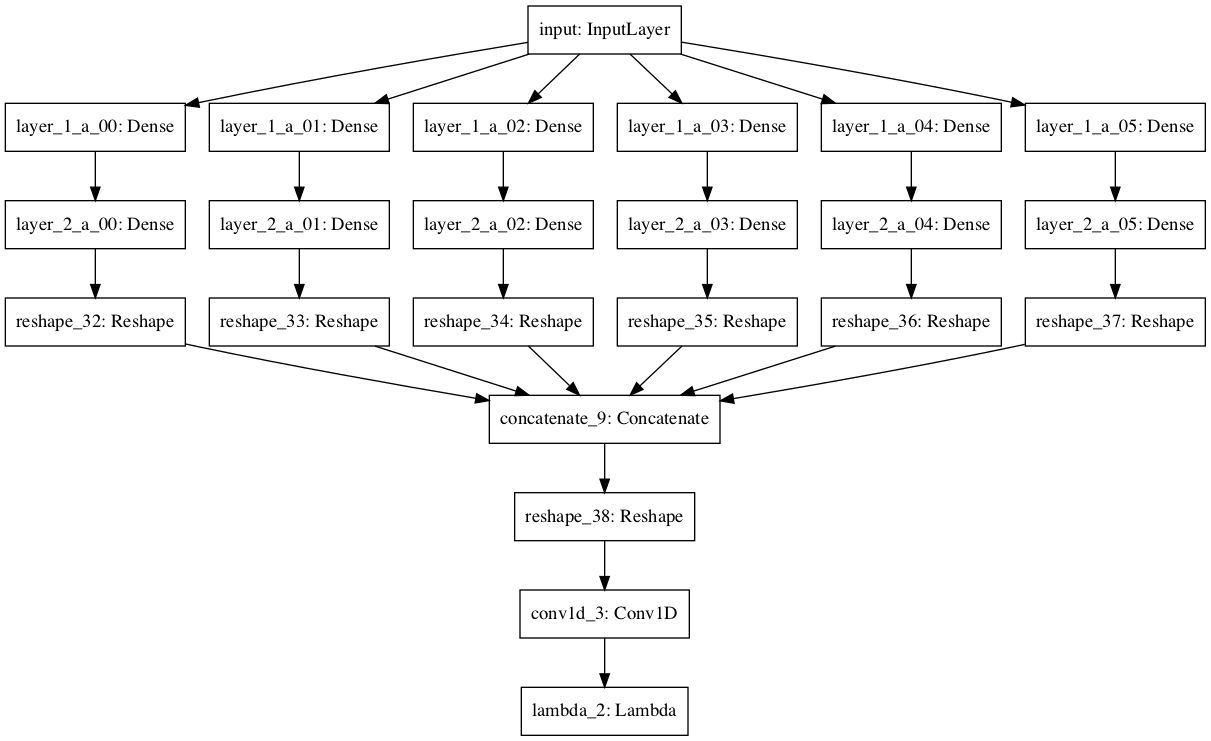

In [29]:
model = create_model(N_SAMPLES, 40)
plot_model(model, to_file='model.png')
Image(retina=True, filename='model.png')

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

# What is an acceptable time for fitting?
model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=3)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
250000/250000 [==============================] - 77s 308us/step - loss: 3.0678e-04
Epoch 2/3
250000/250000 [==============================] - 76s 305us/step - loss: 1.3996e-05
Epoch 3/3
197088/250000 [======================>.......] - ETA: 15s - loss: 8.1971e-06

In [120]:
predictions = model.predict(params)

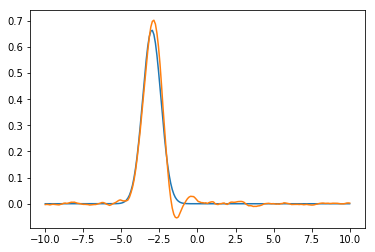

In [122]:
plt.plot(np.linspace(-10, 10, 200), x_sampled[10000, :])
plt.plot(np.linspace(-10, 10, 200), predictions[10000, :])

In [124]:
predictions.shape

(250000, 200)

In [149]:
pred = model.predict(np.array([[1, 1]]))

In [150]:
pred.shape

(1, 200)

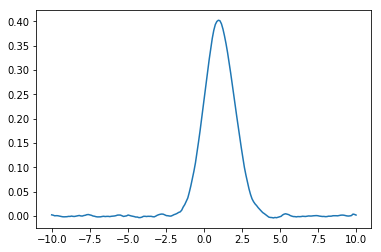

In [151]:
plt.plot(np.linspace(-10, 10, 200), pred[0, :])